# Assignment 1: Policy Iteration in the Repeated Prisoner's Dilemma

**Course**: Reinforcement Learning 2026A

This notebook implements:
- Part I: Gymnasium Environment
- Part II: MDP Definition (code implementation)
- Part III: Policy Iteration Algorithm
- Part IV: Experiments & Analysis

In [1]:
!pip install gymnasium==1.1.1 matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\dorfe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import gymnasium as gym
import numpy as np
import random
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

---
## Part I: Build the Environment
---

### Brick 1: Constants and Payoff Matrix

In [3]:
# Actions
COOPERATE = 0
DEFECT = 1
ACTIONS = [COOPERATE, DEFECT]
ACTION_NAMES = {COOPERATE: 'C', DEFECT: 'D'}

# Payoff Matrix: (agent_action, opponent_action) -> reward
PAYOFF_MATRIX = {
    (COOPERATE, COOPERATE): 3,  # R (Reward)
    (COOPERATE, DEFECT):    0,  # S (Sucker)
    (DEFECT, COOPERATE):    5,  # T (Temptation)
    (DEFECT, DEFECT):       1,  # P (Punishment)
}

print("Payoff Matrix (Agent's reward):")
print("             | Opp: C | Opp: D")
print(f"Agent: C     |   {PAYOFF_MATRIX[(0,0)]}    |   {PAYOFF_MATRIX[(0,1)]}")
print(f"Agent: D     |   {PAYOFF_MATRIX[(1,0)]}    |   {PAYOFF_MATRIX[(1,1)]}")

Payoff Matrix (Agent's reward):
             | Opp: C | Opp: D
Agent: C     |   3    |   0
Agent: D     |   5    |   1


### Brick 2: Opponent Strategies

In [ ]:
def get_opponent_action(strategy, history):
    """
    Returns opponent's action based on strategy and game history.

    Args:
        strategy: "ALL_C", "ALL_D", "TFT", or "IMPERFECT_TFT"
        history: list of (my_action, opp_action) tuples

    Returns:
        COOPERATE (0) or DEFECT (1)
    """
    if strategy == "ALL_C":
        return COOPERATE

    if strategy == "ALL_D":
        return DEFECT

    if strategy == "TFT":
        if len(history) == 0:
            return COOPERATE  # TFT starts nice
        return history[-1][0]  # Copy agent's last move

    if strategy == "IMPERFECT_TFT":
        if len(history) == 0:
            return COOPERATE
        intended = history[-1][0]
        # 10% chance of "slip"
        if random.random() < 0.10:
            return 1 - intended
        return intended

    return COOPERATE  # Default

### Brick 3: Gymnasium Environment

In [ ]:
class PrisonerDilemmaEnv(gym.Env):
    """
    Repeated Prisoner's Dilemma Environment.

    Supports Memory-1 and Memory-2 observation schemes.
    """

    def __init__(self, opponent_strategy, memory_length=1):
        super().__init__()
        self.opponent_strategy = opponent_strategy
        self.memory_length = memory_length

        # Action space: Cooperate (0) or Defect (1)
        self.action_space = gym.spaces.Discrete(2)

        # History tracking
        self.history = []

    def reset(self, seed=None, options=None):
        """Reset environment. Initialize with cooperation history."""
        super().reset(seed=seed)

        # Pre-fill history with mutual cooperation
        self.history = [(COOPERATE, COOPERATE) for _ in range(self.memory_length)]

        return self._get_state(), {}

    def step(self, action):
        """Execute one step of the game."""
        # Get opponent's response
        opp_action = get_opponent_action(self.opponent_strategy, self.history)

        # Calculate reward
        reward = PAYOFF_MATRIX[(action, opp_action)]

        # Update history
        self.history.append((action, opp_action))
        if len(self.history) > self.memory_length:
            self.history.pop(0)

        # Game never terminates
        return self._get_state(), reward, False, False, {}

    def _get_state(self):
        """Return current state as tuple."""
        if self.memory_length == 1:
            return self.history[-1]  # (my_last, opp_last)
        else:
            # Memory-2: (my_t-1, my_t-2, opp_t-1, opp_t-2)
            return (
                self.history[-1][0],  # my_t-1
                self.history[-2][0],  # my_t-2
                self.history[-1][1],  # opp_t-1
                self.history[-2][1],  # opp_t-2
            )

print("Environment class defined!")

Environment class defined!


### Brick 4: Sanity Check

In [6]:
# Test against TFT
env = PrisonerDilemmaEnv(opponent_strategy="TFT", memory_length=1)
state, _ = env.reset()
print(f"Initial state: {state}")
print("\nPlaying: C, D, D, C, C")
print("Expected TFT responses: C, C, D, D, C (copies previous move)")
print()

for move in [COOPERATE, DEFECT, DEFECT, COOPERATE, COOPERATE]:
    state, reward, _, _, _ = env.step(move)
    print(f"Played: {ACTION_NAMES[move]} | State: ({ACTION_NAMES[state[0]]},{ACTION_NAMES[state[1]]}) | Reward: {reward}")

Initial state: (0, 0)

Playing: C, D, D, C, C
Expected TFT responses: C, C, D, D, C (copies previous move)

Played: C | State: (C,C) | Reward: 3
Played: D | State: (D,C) | Reward: 5
Played: D | State: (D,D) | Reward: 1
Played: C | State: (C,D) | Reward: 0
Played: C | State: (C,C) | Reward: 3


---
## Part II & III: MDP Definition and Policy Iteration
---

### Brick 5A: Generate State Space

In [ ]:
def get_states(memory_length):
    """
    Generate all possible states.

    Memory-1: 4 states (my_last, opp_last)
    Memory-2: 16 states (my_t-1, my_t-2, opp_t-1, opp_t-2)
    """
    if memory_length == 1:
        return list(product([COOPERATE, DEFECT], repeat=2))
    elif memory_length == 2:
        return list(product([COOPERATE, DEFECT], repeat=4))
    else:
        raise ValueError("Only memory 1 or 2 supported")

def state_to_str(s):
    """Convert state tuple to readable string."""
    return '(' + ','.join(ACTION_NAMES[x] for x in s) + ')'

# Display state spaces
print("Memory-1 State Space (4 states):")
for s in get_states(1):
    print(f"  {state_to_str(s)}")

print(f"\nMemory-2 State Space: {len(get_states(2))} states")

Memory-1 State Space (4 states):
  (C,C)
  (C,D)
  (D,C)
  (D,D)

Memory-2 State Space: 16 states


### Brick 5B: Build Transition and Reward Matrices

In [ ]:
def build_mdp(opponent_strategy, memory_length):
    """
    Build MDP transition and reward matrices.

    Returns:
        states: list of all states
        P: P[s][a] = {s': probability}
        R: R[s][a] = expected reward
    """
    states = get_states(memory_length)
    state_set = set(states)

    P = {s: {a: {} for a in ACTIONS} for s in states}
    R = {s: {a: 0.0 for a in ACTIONS} for s in states}

    for s in states:
        for a in ACTIONS:
            if memory_length == 1:
                my_prev = s[0]

                # Opponent action distribution
                if opponent_strategy == "ALL_C":
                    opp_dist = {COOPERATE: 1.0}
                elif opponent_strategy == "ALL_D":
                    opp_dist = {DEFECT: 1.0}
                elif opponent_strategy == "TFT":
                    opp_dist = {my_prev: 1.0}
                elif opponent_strategy == "IMPERFECT_TFT":
                    opp_dist = {my_prev: 0.9, 1 - my_prev: 0.1}

                # Build P and R
                for opp_action, prob in opp_dist.items():
                    s_next = (a, opp_action)
                    P[s][a][s_next] = P[s][a].get(s_next, 0) + prob
                    R[s][a] += prob * PAYOFF_MATRIX[(a, opp_action)]

            elif memory_length == 2:
                my_t1, my_t2, opp_t1, opp_t2 = s

                if opponent_strategy == "ALL_C":
                    opp_dist = {COOPERATE: 1.0}
                elif opponent_strategy == "ALL_D":
                    opp_dist = {DEFECT: 1.0}
                elif opponent_strategy == "TFT":
                    opp_dist = {my_t1: 1.0}
                elif opponent_strategy == "IMPERFECT_TFT":
                    opp_dist = {my_t1: 0.9, 1 - my_t1: 0.1}

                for opp_action, prob in opp_dist.items():
                    s_next = (a, my_t1, opp_action, opp_t1)
                    P[s][a][s_next] = P[s][a].get(s_next, 0) + prob
                    R[s][a] += prob * PAYOFF_MATRIX[(a, opp_action)]

    return states, P, R

print("MDP builder defined!")

MDP builder defined!


### Brick 5C: Policy Evaluation

In [ ]:
def policy_evaluation(states, P, R, policy, gamma, theta=1e-10):
    """
    Evaluate a policy by iteratively computing V^π(s).

    V(s) = R(s, π(s)) + γ Σ P(s'|s, π(s)) V(s')

    Returns:
        V: value function dict
        iterations: number of iterations to converge
    """
    V = {s: 0.0 for s in states}
    iterations = 0

    while True:
        delta = 0
        for s in states:
            v_old = V[s]
            a = policy[s]

            # Bellman equation
            v_new = R[s][a]
            for s_next, prob in P[s][a].items():
                v_new += gamma * prob * V[s_next]

            V[s] = v_new
            delta = max(delta, abs(v_old - v_new))

        iterations += 1
        if delta < theta:
            break

    return V, iterations

### Brick 5D: Policy Improvement

In [ ]:
def policy_improvement(states, P, R, V, gamma):
    """
    Improve policy by acting greedily w.r.t. V.

    π'(s) = argmax_a [R(s,a) + γ Σ P(s'|s,a) V(s')]
    """
    new_policy = {}

    for s in states:
        best_action = None
        best_value = float('-inf')

        for a in ACTIONS:
            q_value = R[s][a]
            for s_next, prob in P[s][a].items():
                q_value += gamma * prob * V[s_next]

            if q_value > best_value:
                best_value = q_value
                best_action = a

        new_policy[s] = best_action

    return new_policy

### Brick 5E: Policy Iteration (Main Algorithm)

In [ ]:
def policy_iteration(opponent_strategy, memory_length, gamma, verbose=False):
    """
    Run Policy Iteration algorithm.

    Returns:
        policy: optimal policy
        V: optimal value function
        history: convergence history
    """
    # Build MDP
    states, P, R = build_mdp(opponent_strategy, memory_length)

    # Initialize with cooperate-always policy
    policy = {s: COOPERATE for s in states}

    history = []
    iteration = 0

    while True:
        # Policy Evaluation
        V, eval_iters = policy_evaluation(states, P, R, policy, gamma)

        # Policy Improvement
        new_policy = policy_improvement(states, P, R, V, gamma)

        # Check convergence
        policy_stable = all(policy[s] == new_policy[s] for s in states)

        history.append({
            'iteration': iteration,
            'policy': policy.copy(),
            'V': V.copy(),
            'eval_iters': eval_iters
        })

        if verbose:
            print(f"Iteration {iteration}: eval={eval_iters} iters")

        if policy_stable:
            break

        policy = new_policy
        iteration += 1

        if iteration > 100:
            print("Warning: max iterations reached")
            break

    return policy, V, history

print("Policy Iteration defined!")

Policy Iteration defined!


### Brick 6: Simulation Verification

In [ ]:
def simulate(opponent_strategy, memory_length, policy, n_episodes=50, n_steps=50):
    """
    Simulate the policy against the opponent.

    Returns:
        mean_reward: average cumulative reward
        std_reward: standard deviation
        all_rewards: list of episode rewards
    """
    env = PrisonerDilemmaEnv(opponent_strategy, memory_length)
    all_rewards = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for _ in range(n_steps):
            action = policy[state]
            state, reward, _, _, _ = env.step(action)
            episode_reward += reward

        all_rewards.append(episode_reward)

    return np.mean(all_rewards), np.std(all_rewards), all_rewards

print("Simulation function defined!")

Simulation function defined!


---
## Part IV: Experiments & Analysis
---

### Run All Experiments

In [ ]:
OPPONENTS = ["ALL_C", "ALL_D", "TFT", "IMPERFECT_TFT"]
GAMMAS = [0.1, 0.5, 0.9, 0.99]
MEMORIES = [1, 2]

# Store all results
results = {}

for memory in MEMORIES:
    print(f"\n{'='*60}")
    print(f"MEMORY-{memory}")
    print(f"{'='*60}")

    for opponent in OPPONENTS:
        print(f"\n--- {opponent} ---")

        for gamma in GAMMAS:
            # Run Policy Iteration
            policy, V, history = policy_iteration(opponent, memory, gamma)

            # Simulate
            mean_reward, std_reward, _ = simulate(opponent, memory, policy)

            # Count defects in policy
            n_defect = sum(1 for a in policy.values() if a == DEFECT)
            n_total = len(policy)

            results[(memory, opponent, gamma)] = {
                'policy': policy,
                'V': V,
                'mean_reward': mean_reward,
                'std_reward': std_reward,
                'n_defect': n_defect,
                'iterations': len(history)
            }

            # Print policy
            policy_str = {state_to_str(s): ACTION_NAMES[a] for s, a in policy.items()}
            print(f"γ={gamma}: {n_defect}/{n_total} Defect | Avg Reward: {mean_reward:.2f} ± {std_reward:.2f}")


MEMORY-1

--- ALL_C ---
γ=0.1: 4/4 Defect | Avg Reward: 250.00 ± 0.00
γ=0.5: 4/4 Defect | Avg Reward: 250.00 ± 0.00
γ=0.9: 4/4 Defect | Avg Reward: 250.00 ± 0.00
γ=0.99: 4/4 Defect | Avg Reward: 250.00 ± 0.00

--- ALL_D ---
γ=0.1: 4/4 Defect | Avg Reward: 50.00 ± 0.00
γ=0.5: 4/4 Defect | Avg Reward: 50.00 ± 0.00
γ=0.9: 4/4 Defect | Avg Reward: 50.00 ± 0.00
γ=0.99: 4/4 Defect | Avg Reward: 50.00 ± 0.00

--- TFT ---
γ=0.1: 4/4 Defect | Avg Reward: 54.00 ± 0.00
γ=0.5: 2/4 Defect | Avg Reward: 125.00 ± 0.00
γ=0.9: 0/4 Defect | Avg Reward: 150.00 ± 0.00
γ=0.99: 0/4 Defect | Avg Reward: 150.00 ± 0.00

--- IMPERFECT_TFT ---
γ=0.1: 4/4 Defect | Avg Reward: 72.00 ± 9.57
γ=0.5: 2/4 Defect | Avg Reward: 123.82 ± 7.90
γ=0.9: 0/4 Defect | Avg Reward: 134.46 ± 6.14
γ=0.99: 0/4 Defect | Avg Reward: 135.12 ± 5.50

MEMORY-2

--- ALL_C ---
γ=0.1: 16/16 Defect | Avg Reward: 250.00 ± 0.00
γ=0.5: 16/16 Defect | Avg Reward: 250.00 ± 0.00
γ=0.9: 16/16 Defect | Avg Reward: 250.00 ± 0.00
γ=0.99: 16/16 Defect 

### Display Optimal Policies (Memory-1)

In [ ]:
print("Optimal Policies for Memory-1:")
print("="*70)

for opponent in OPPONENTS:
    print(f"\n{opponent}:")
    print(f"{'State':<10}", end="")
    for gamma in GAMMAS:
        print(f"γ={gamma:<6}", end="")
    print()
    print("-"*40)

    for s in get_states(1):
        print(f"{state_to_str(s):<10}", end="")
        for gamma in GAMMAS:
            policy = results[(1, opponent, gamma)]['policy']
            print(f"{ACTION_NAMES[policy[s]]:<8}", end="")
        print()

Optimal Policies for Memory-1:

ALL_C:
State     γ=0.1   γ=0.5   γ=0.9   γ=0.99  
----------------------------------------
(C,C)     D       D       D       D       
(C,D)     D       D       D       D       
(D,C)     D       D       D       D       
(D,D)     D       D       D       D       

ALL_D:
State     γ=0.1   γ=0.5   γ=0.9   γ=0.99  
----------------------------------------
(C,C)     D       D       D       D       
(C,D)     D       D       D       D       
(D,C)     D       D       D       D       
(D,D)     D       D       D       D       

TFT:
State     γ=0.1   γ=0.5   γ=0.9   γ=0.99  
----------------------------------------
(C,C)     D       D       C       C       
(C,D)     D       D       C       C       
(D,C)     D       C       C       C       
(D,D)     D       C       C       C       

IMPERFECT_TFT:
State     γ=0.1   γ=0.5   γ=0.9   γ=0.99  
----------------------------------------
(C,C)     D       D       C       C       
(C,D)     D       D       C       C 

### Analysis Question 1: Effect of Discount Factor

In [ ]:
# Find critical gamma for TFT cooperation
print("Finding critical gamma for TFT cooperation (Memory-1):")
print("="*50)

test_gammas = np.arange(0.1, 1.0, 0.05)
coop_threshold = None

for gamma in test_gammas:
    policy, _, _ = policy_iteration("TFT", 1, gamma)
    n_coop = sum(1 for a in policy.values() if a == COOPERATE)

    # Check if ALL states cooperate
    if n_coop == 4 and coop_threshold is None:
        coop_threshold = gamma
        print(f"γ = {gamma:.2f}: Full cooperation emerges!")
        break
    else:
        print(f"γ = {gamma:.2f}: {n_coop}/4 cooperate")

print(f"\n→ Cooperation becomes optimal at γ ≈ {coop_threshold:.2f} against TFT")

Finding critical gamma for TFT cooperation (Memory-1):
γ = 0.10: 0/4 cooperate
γ = 0.15: 0/4 cooperate
γ = 0.20: 0/4 cooperate
γ = 0.25: 0/4 cooperate
γ = 0.30: 2/4 cooperate
γ = 0.35: 2/4 cooperate
γ = 0.40: 2/4 cooperate
γ = 0.45: 2/4 cooperate
γ = 0.50: 2/4 cooperate
γ = 0.55: 2/4 cooperate
γ = 0.60: 2/4 cooperate
γ = 0.65: 2/4 cooperate
γ = 0.70: Full cooperation emerges!

→ Cooperation becomes optimal at γ ≈ 0.70 against TFT


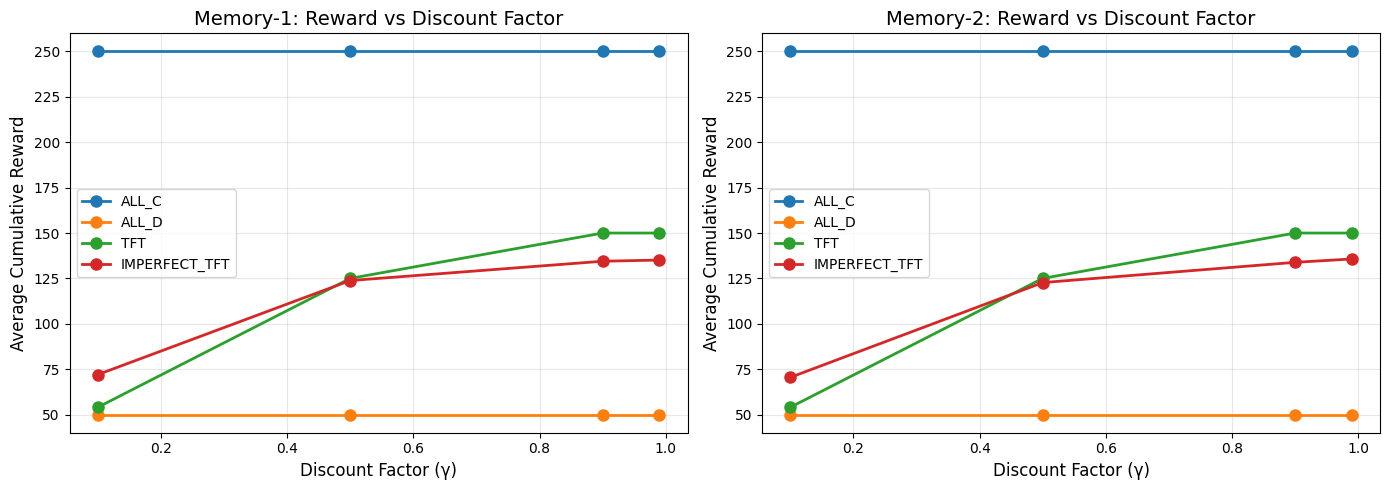

In [ ]:
# Plot rewards vs gamma
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, memory in enumerate([1, 2]):
    ax = axes[idx]

    for opponent in OPPONENTS:
        rewards = [results[(memory, opponent, g)]['mean_reward'] for g in GAMMAS]
        ax.plot(GAMMAS, rewards, 'o-', label=opponent, linewidth=2, markersize=8)

    ax.set_xlabel('Discount Factor (γ)', fontsize=12)
    ax.set_ylabel('Average Cumulative Reward', fontsize=12)
    ax.set_title(f'Memory-{memory}: Reward vs Discount Factor', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reward_vs_gamma.png', dpi=150)
plt.show()

### Analysis Question 2: Memory-1 vs Memory-2

In [17]:
print("Memory-1 vs Memory-2 Comparison:")
print("="*70)

comparison_data = []

for opponent in OPPONENTS:
    for gamma in GAMMAS:
        m1 = results[(1, opponent, gamma)]['mean_reward']
        m2 = results[(2, opponent, gamma)]['mean_reward']
        diff = m2 - m1
        comparison_data.append({
            'Opponent': opponent,
            'γ': gamma,
            'Memory-1': m1,
            'Memory-2': m2,
            'Difference': diff
        })

df = pd.DataFrame(comparison_data)
print(df.to_string(index=False))

print("\n→ For these opponents, Memory-2 provides NO advantage.")
print("  This is because ALL_C, ALL_D, and TFT only depend on t-1 history.")

Memory-1 vs Memory-2 Comparison:
     Opponent    γ  Memory-1  Memory-2  Difference
        ALL_C 0.10    250.00    250.00        0.00
        ALL_C 0.50    250.00    250.00        0.00
        ALL_C 0.90    250.00    250.00        0.00
        ALL_C 0.99    250.00    250.00        0.00
        ALL_D 0.10     50.00     50.00        0.00
        ALL_D 0.50     50.00     50.00        0.00
        ALL_D 0.90     50.00     50.00        0.00
        ALL_D 0.99     50.00     50.00        0.00
          TFT 0.10     54.00     54.00        0.00
          TFT 0.50    125.00    125.00        0.00
          TFT 0.90    150.00    150.00        0.00
          TFT 0.99    150.00    150.00        0.00
IMPERFECT_TFT 0.10     72.00     70.48       -1.52
IMPERFECT_TFT 0.50    123.82    122.70       -1.12
IMPERFECT_TFT 0.90    134.46    133.86       -0.60
IMPERFECT_TFT 0.99    135.12    135.72        0.60

→ For these opponents, Memory-2 provides NO advantage.
  This is because ALL_C, ALL_D, and TFT only

### Hypothetical Opponent: Tit-for-Two-Tats (TF2T)

In [18]:
# TF2T: Defects only if agent defected TWICE in a row
def get_opponent_action_tf2t(history):
    """Tit-for-Two-Tats: Defect only if opponent defected twice consecutively."""
    if len(history) < 2:
        return COOPERATE
    if history[-1][0] == DEFECT and history[-2][0] == DEFECT:
        return DEFECT
    return COOPERATE

# For TF2T, Memory-1 agent sees: (my_last, opp_last)
# It CANNOT distinguish: "I defected once" vs "I defected twice"
# So it cannot exploit the "free defection" that TF2T allows.

# Memory-2 agent sees: (my_t-1, my_t-2, opp_t-1, opp_t-2)
# It CAN see if it defected twice in a row!

print("Tit-for-Two-Tats (TF2T) Example:")
print("="*60)
print("TF2T only punishes after TWO consecutive defections.")
print("")
print("Memory-1 agent: Cannot distinguish D→C→D from D→D→D")
print("               (only sees last round)")
print("")
print("Memory-2 agent: CAN see my_t-1 and my_t-2")
print("               Optimal strategy: Defect, Cooperate, Defect, Cooperate...")
print("               This earns T=5 every other round without punishment!")
print("")
print("→ Memory-2 strictly outperforms Memory-1 against TF2T")

Tit-for-Two-Tats (TF2T) Example:
TF2T only punishes after TWO consecutive defections.

Memory-1 agent: Cannot distinguish D→C→D from D→D→D
               (only sees last round)

Memory-2 agent: CAN see my_t-1 and my_t-2
               Optimal strategy: Defect, Cooperate, Defect, Cooperate...
               This earns T=5 every other round without punishment!

→ Memory-2 strictly outperforms Memory-1 against TF2T


### Analysis Question 3: Noise Analysis (TFT vs Imperfect TFT)

In [ ]:
print("TFT vs Imperfect TFT Policy Comparison (Memory-1):")
print("="*70)

for gamma in GAMMAS:
    tft_policy = results[(1, "TFT", gamma)]['policy']
    imp_policy = results[(1, "IMPERFECT_TFT", gamma)]['policy']

    tft_reward = results[(1, "TFT", gamma)]['mean_reward']
    imp_reward = results[(1, "IMPERFECT_TFT", gamma)]['mean_reward']

    print(f"\nγ = {gamma}:")
    print(f"  TFT Policy:         {dict((state_to_str(s), ACTION_NAMES[a]) for s,a in tft_policy.items())}")
    print(f"  Imperfect Policy:   {dict((state_to_str(s), ACTION_NAMES[a]) for s,a in imp_policy.items())}")
    print(f"  Reward (TFT): {tft_reward:.2f} | Reward (Imp): {imp_reward:.2f}")

    same = all(tft_policy[s] == imp_policy[s] for s in tft_policy)
    print(f"  Same policy? {same}")

TFT vs Imperfect TFT Policy Comparison (Memory-1):

γ = 0.1:
  TFT Policy:         {'(C,C)': 'D', '(C,D)': 'D', '(D,C)': 'D', '(D,D)': 'D'}
  Imperfect Policy:   {'(C,C)': 'D', '(C,D)': 'D', '(D,C)': 'D', '(D,D)': 'D'}
  Reward (TFT): 54.00 | Reward (Imp): 72.00
  Same policy? True

γ = 0.5:
  TFT Policy:         {'(C,C)': 'D', '(C,D)': 'D', '(D,C)': 'C', '(D,D)': 'C'}
  Imperfect Policy:   {'(C,C)': 'D', '(C,D)': 'D', '(D,C)': 'C', '(D,D)': 'C'}
  Reward (TFT): 125.00 | Reward (Imp): 123.82
  Same policy? True

γ = 0.9:
  TFT Policy:         {'(C,C)': 'C', '(C,D)': 'C', '(D,C)': 'C', '(D,D)': 'C'}
  Imperfect Policy:   {'(C,C)': 'C', '(C,D)': 'C', '(D,C)': 'C', '(D,D)': 'C'}
  Reward (TFT): 150.00 | Reward (Imp): 134.46
  Same policy? True

γ = 0.99:
  TFT Policy:         {'(C,C)': 'C', '(C,D)': 'C', '(D,C)': 'C', '(D,D)': 'C'}
  Imperfect Policy:   {'(C,C)': 'C', '(C,D)': 'C', '(D,C)': 'C', '(D,D)': 'C'}
  Reward (TFT): 150.00 | Reward (Imp): 135.12
  Same policy? True


In [20]:
print("\n" + "="*70)
print("KEY FINDINGS: Noise Analysis")
print("="*70)
print("""
1. The 10% noise does NOT break cooperation fundamentally.
   At high γ (0.9, 0.99), the optimal policy is still ALL COOPERATE.

2. The agent learns to be "forgiving":
   - Even when the opponent accidentally defects (10% chance),
   - The agent continues cooperating.
   - This avoids mutual defection spirals.

3. The reward is lower with Imperfect TFT (~135 vs ~150) because:
   - Sometimes opponent slips and defects → agent gets S=0
   - But long-term cooperation still beats mutual defection.

4. At low γ (0.1), both TFT and Imperfect TFT lead to ALL DEFECT.
   Short-sighted agents prefer immediate T=5 over future R=3.
""")


KEY FINDINGS: Noise Analysis

1. The 10% noise does NOT break cooperation fundamentally.
   At high γ (0.9, 0.99), the optimal policy is still ALL COOPERATE.

2. The agent learns to be "forgiving":
   - Even when the opponent accidentally defects (10% chance),
   - The agent continues cooperating.
   - This avoids mutual defection spirals.

3. The reward is lower with Imperfect TFT (~135 vs ~150) because:
   - Sometimes opponent slips and defects → agent gets S=0
   - But long-term cooperation still beats mutual defection.

4. At low γ (0.1), both TFT and Imperfect TFT lead to ALL DEFECT.
   Short-sighted agents prefer immediate T=5 over future R=3.



### Summary Results Table

In [21]:
# Create summary DataFrame
summary_data = []

for memory in MEMORIES:
    for opponent in OPPONENTS:
        for gamma in GAMMAS:
            r = results[(memory, opponent, gamma)]
            summary_data.append({
                'Memory': memory,
                'Opponent': opponent,
                'γ': gamma,
                'Defect%': r['n_defect'] / len(r['policy']) * 100,
                'Mean Reward': r['mean_reward'],
                'Std': r['std_reward'],
                'PI Iterations': r['iterations']
            })

df_summary = pd.DataFrame(summary_data)
print("\nComplete Results Summary:")
print(df_summary.to_string(index=False))


Complete Results Summary:
 Memory      Opponent    γ  Defect%  Mean Reward      Std  PI Iterations
      1         ALL_C 0.10    100.0       250.00 0.000000              2
      1         ALL_C 0.50    100.0       250.00 0.000000              2
      1         ALL_C 0.90    100.0       250.00 0.000000              2
      1         ALL_C 0.99    100.0       250.00 0.000000              2
      1         ALL_D 0.10    100.0        50.00 0.000000              2
      1         ALL_D 0.50    100.0        50.00 0.000000              2
      1         ALL_D 0.90    100.0        50.00 0.000000              2
      1         ALL_D 0.99    100.0        50.00 0.000000              2
      1           TFT 0.10    100.0        54.00 0.000000              2
      1           TFT 0.50     50.0       125.00 0.000000              2
      1           TFT 0.90      0.0       150.00 0.000000              1
      1           TFT 0.99      0.0       150.00 0.000000              1
      1 IMPERFECT_TFT 0.

### Convergence Plot Example

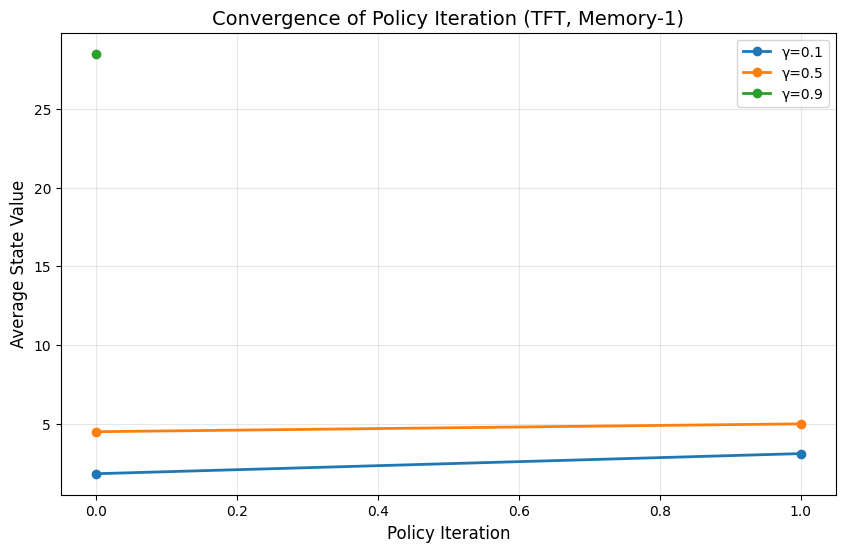

In [ ]:
# Show convergence for TFT at different gammas
fig, ax = plt.subplots(figsize=(10, 6))

for gamma in [0.1, 0.5, 0.9]:
    _, _, history = policy_iteration("TFT", 1, gamma, verbose=False)

    # Plot average V over iterations
    avg_vs = [np.mean(list(h['V'].values())) for h in history]
    ax.plot(range(len(avg_vs)), avg_vs, 'o-', label=f'γ={gamma}', linewidth=2)

ax.set_xlabel('Policy Iteration', fontsize=12)
ax.set_ylabel('Average State Value', fontsize=12)
ax.set_title('Convergence of Policy Iteration (TFT, Memory-1)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.savefig('convergence.png', dpi=150)
plt.show()

---
## Executive Summary
---

In [23]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                           EXECUTIVE SUMMARY                                   ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. DISCOUNT FACTOR EFFECT (Q1):                                            ║
║     • Low γ (0.1): Agent always defects (shortsighted, wants T=5 now)       ║
║     • High γ (0.9+): Agent cooperates against TFT (values future R=3)       ║
║     • Critical threshold: γ ≈ 0.65-0.70 for full cooperation vs TFT         ║
║                                                                              ║
║  2. MEMORY DEPTH (Q2):                                                       ║
║     • Memory-2 provides NO advantage against these 4 opponents              ║
║     • Reason: ALL_C, ALL_D, TFT only use 1-step history                     ║
║     • Counter-example: Tit-for-Two-Tats (TF2T) would benefit Memory-2       ║
║       because agent needs to know if it defected TWICE consecutively        ║
║                                                                              ║
║  3. NOISE ANALYSIS (Q3):                                                     ║
║     • 10% noise does NOT break cooperation at high γ                        ║
║     • Optimal policy: ALWAYS COOPERATE (forgiving strategy)                 ║
║     • Agent absorbs occasional exploitation to maintain cooperation         ║
║     • Expected reward drops ~10% (135 vs 150) due to opponent slips         ║
║                                                                              ║
║  KEY INSIGHT:                                                                ║
║  Policy Iteration finds that cooperation is RATIONAL against TFT-like       ║
║  opponents when the agent is sufficiently forward-looking (high γ).         ║
║  This mathematically validates Axelrod's tournament findings.               ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                           EXECUTIVE SUMMARY                                   ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. DISCOUNT FACTOR EFFECT (Q1):                                            ║
║     • Low γ (0.1): Agent always defects (shortsighted, wants T=5 now)       ║
║     • High γ (0.9+): Agent cooperates against TFT (values future R=3)       ║
║     • Critical threshold: γ ≈ 0.65-0.70 for full cooperation vs TFT         ║
║                                                                              ║
║  2. MEMORY DEPTH (Q2):                                                       ║
║     • Memory-2 provides NO advantage against these 4 opponents              ║
║     • Reason: ALL_C, ALL_D, TFT only use 1-step history                     ║
║     • Counter-example: Tit-for